In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [2]:
names = open("names.txt", "r").read().splitlines()
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [3]:
def build_dataset(names):
    block_size = 3 #context length of how many chars we take to predict the next char
    X, Y = [],[]
    
    for w in names:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # rolling window, makes sense when you run it
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [4]:

import random
random.seed(42)
random.shuffle(names)
X_train, Y_train = build_dataset(names[:int(0.8*len(names))]) #get first 80% of the dataset
X_valid, Y_valid = build_dataset(names[int(0.8*len(names)):int(0.9*len(names))]) # get between 80%-90%
X_test, Y_test = build_dataset(names[int(0.9*len(names)):]) # get last 10% of dataset

block_size = 3
vocab_size = len(itos)

In [24]:
class Linear:
                     #examples,#neurons
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params, (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers, (trained with a running momentum)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True) # batch mean
            xvar = x.var(0, keepdims=True, unbiased=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma(xhat + self.beta)
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean*(1-self.momentum) + xmean*self.momentum
                self.running_var = self.running_var*(1-self.momentum) + xvar*self.momentum
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

            #size straight from paper
C = torch.randn((vocab_size, n_emb),            generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters)) # number of parms in total
for p in parameters:
   p.requires_grad = True


46497


In [48]:
# optimization
max_steps = 100000
batch_size = 32
lossi = []
ud = [] # update:data ratio (lr*gradient).std / parameter.data.std

for i in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
       layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps/2 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break
print(loss)
#print(ud)

      0/ 100000: 2.0182
tensor(2.5089, grad_fn=<NllLossBackward0>)


## Visualizing the activations
#### We can see that since we have a tanh activation function, and we put our gain to be in 5/3, weights will have an equal distribution in each layer. If we try to tweak the gain to be smaller than 5/3, say 0.2, then our activations will shrink towards 0. If we do the opposite, activations will really disperse and they will all be -1 and 1, and our gradients will thus be 0 or close to 0 (for 1 single optim. iter).

layer 1 (      Tanh): mean -0.05, std 0.78, saturated: 24.72%
layer 3 (      Tanh): mean -0.00, std 0.77, saturated: 18.38%
layer 5 (      Tanh): mean -0.01, std 0.79, saturated: 23.22%
layer 7 (      Tanh): mean -0.05, std 0.80, saturated: 23.34%
layer 9 (      Tanh): mean -0.00, std 0.73, saturated: 14.22%


Text(0.5, 1.0, 'activation distribution')

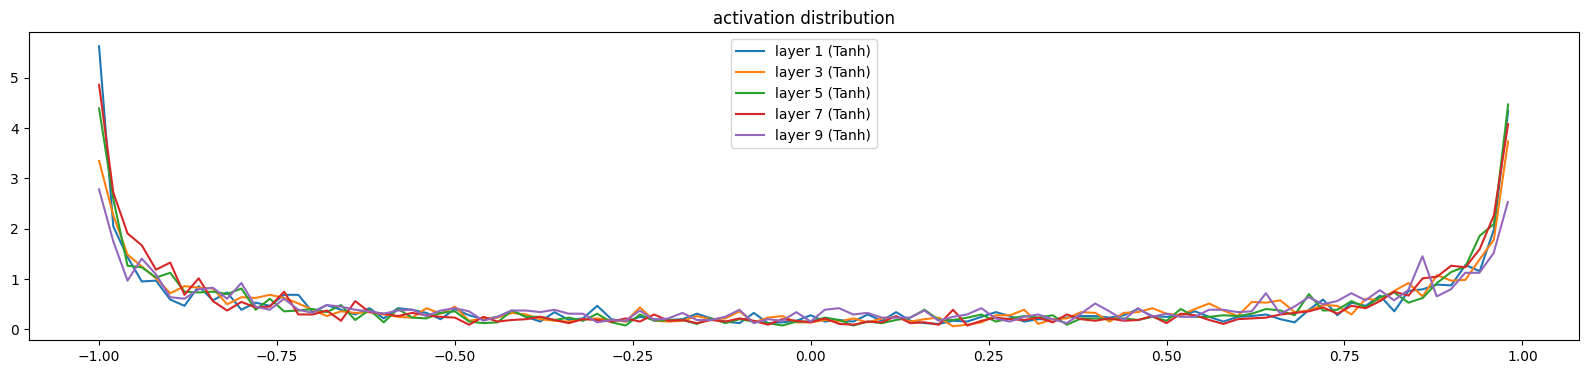

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}'')')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean -0.000001, std 2.759953e-03
layer 3 (      Tanh): mean +0.000002, std 2.613406e-03
layer 5 (      Tanh): mean +0.000107, std 2.741161e-03
layer 7 (      Tanh): mean +0.000148, std 3.360936e-03
layer 9 (      Tanh): mean -0.000030, std 3.224125e-03


Text(0.5, 1.0, 'gradient distribution')

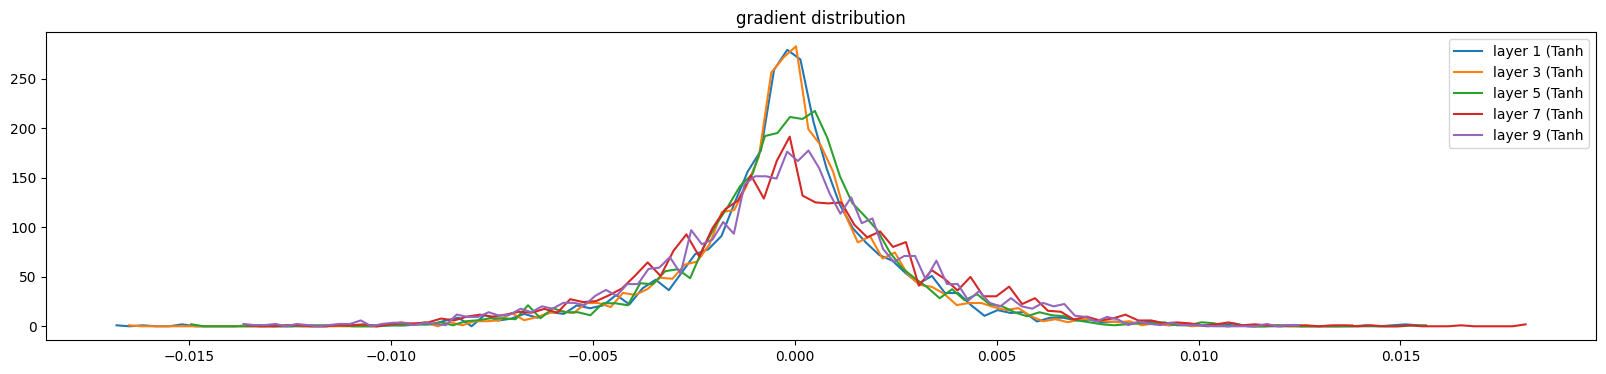

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

### It is also important that we look at the scale of the gradient compared to the scale of the actual values (data)
#### if the gradient has too large of a magnitude compares to the numbers in data, then we would be in trouble.
#### The gradients in the last layer are about 2x bigger than the values, but in all other layers, they're about 1000 times smaller than values in our data. Also, the std in the last layer is 10-100x smaller than std in our other layers. So the gradients in the last layer are ~10x greater than all other weights inside the neural net. This is a problem because in a simple stochastic gradient descent setup, we would be training the last layer about 10x faster than all of our other layers.
#### this kind of fixes itself a little bit if we train for ~1000 steps instead of just 1, but it is still something to be careful of if we are using an optimizer like gradient descent.

weight   (27, 10) | mean +0.001195 | std 1.219485e-02 | grad:data ratio 1.201894e-02
weight  (30, 100) | mean +0.000254 | std 9.147058e-03 | grad:data ratio 2.839653e-02
weight (100, 100) | mean +0.000042 | std 6.779072e-03 | grad:data ratio 3.825184e-02
weight (100, 100) | mean +0.000006 | std 6.179999e-03 | grad:data ratio 3.488017e-02
weight (100, 100) | mean -0.000024 | std 6.794179e-03 | grad:data ratio 3.861844e-02
weight (100, 100) | mean +0.000102 | std 8.428154e-03 | grad:data ratio 4.913773e-02
weight  (100, 27) | mean +0.000000 | std 2.489070e-02 | grad:data ratio 2.481640e-01


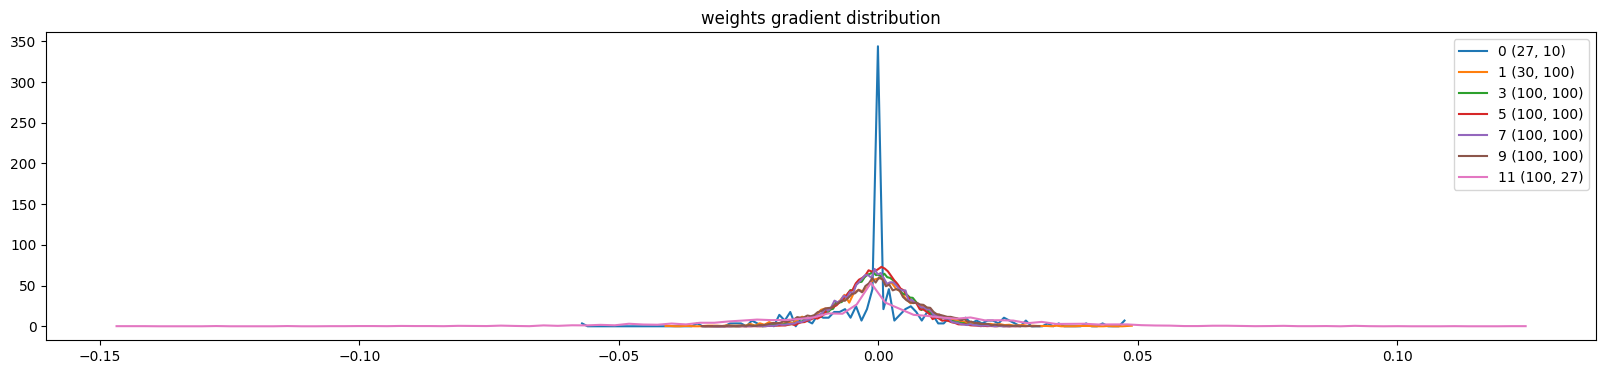

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


### Even more important thing to look at is the update to data ratio, since that is the amount by which we will actually change the data in our tensors.
#### The ratios should always be roughly 1e-3. This means that there are some values in these tensors that take on certain values, and the updates to them at every single iteration, are no more than one-thounsandth of the magnitude of those values. If the log of it was only -1 (log<sub>10</sub>(update/data) = -1 , update/data = 10^-1 = 0.1, data is 10x bigger than the update), that would be updating the values by 1/10 of their magnitude, which would be too much. Also, if the log of this ratio is -4 or less, then the updates would be too small and the net would be learning too slowly (log<sub>10</sub>(update/data) = -4, update/data = 0.0001 -> data is 10000 bigger than the update)

#### since we artificially shrunk down the last layer (by a factor of 10) to keep it less confident, it made the values inside of the tensor way too low, which made the data smaller, which makes the update/data bigger.

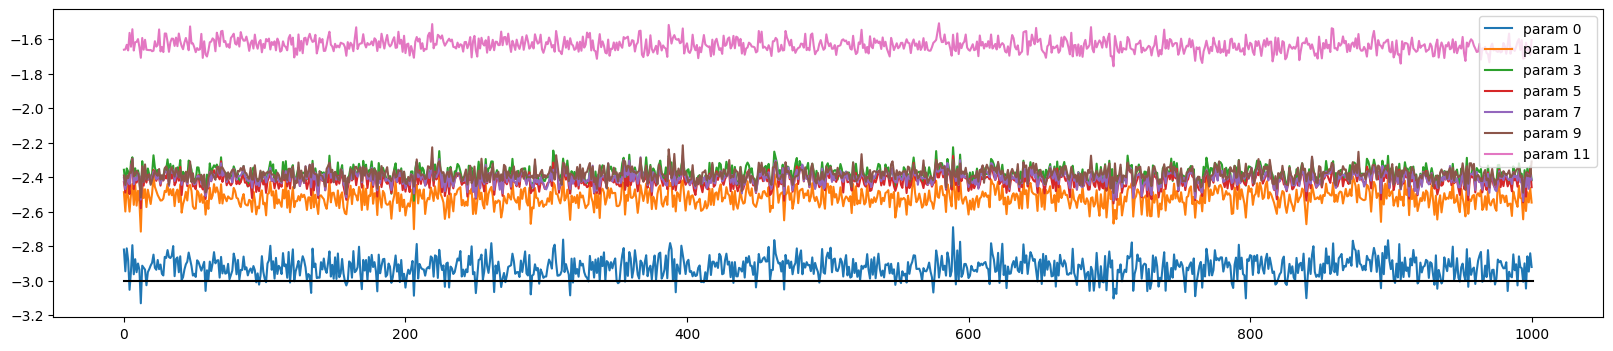

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
